In [3]:
# check mlx device
import mlx.core as mx
mx.default_device()

Device(gpu, 0)

In [138]:
import mlx.core as mx

# mx.set_default_device(mx.cpu) # Uncomment to set the default device to CPU

@mx.compile
def find_index_1d_mlx(x_array, x_new):
    N = x_array.shape[0]
    # Find index where x_new would be inserted to keep array sorted
    # This is equivalent to searchsorted with side='right' - 1
    i = mx.sum(x_array <= x_new) - 1
    
    # Clip to 1, N-3
    i = mx.clip(i, 1, N - 3)

    # Condition for edge handling (same as Numba version)
    condition_i = mx.where(x_new <= x_array[1], 1,
                  mx.where(x_new >= x_array[N-2], 3, 2))
    return i, condition_i

x_array = mx.arange(0., 10., 1., dtype=mx.float32)
size = 5
x_new = mx.linspace(0., 10., size, dtype=mx.float32)
i, condition_i = mx.vmap(find_index_1d_mlx, in_axes=(None, 0))(x_array, x_new)
i_0 = mx.eval(i[1])
print(f"Index: {i}, Condition: {condition_i}")

Index: array([1, 2, 5, 7, 7], dtype=int32), Condition: array([1, 2, 2, 2, 3], dtype=int32)


In [140]:
type(i_0)

NoneType

Size 1000: 0.001729 s
Size 112000: 0.000779 s
Size 223000: 0.001876 s
Size 334000: 0.000875 s
Size 445000: 0.000959 s
Size 556000: 0.001112 s
Size 667000: 0.001338 s
Size 778000: 0.000985 s
Size 889000: 0.001530 s
Size 1000000: 0.001102 s


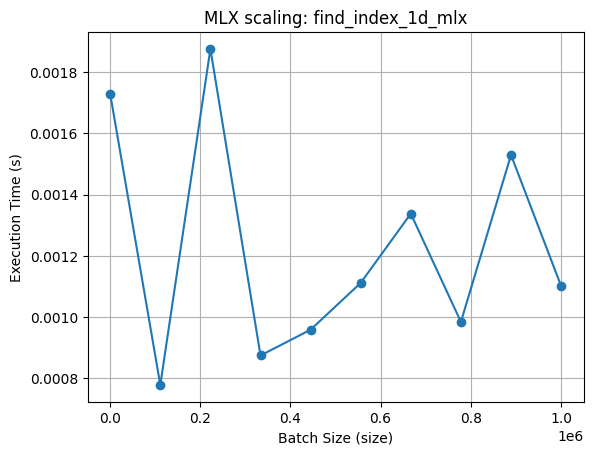

In [1]:
import mlx.core as mx
import time
import numpy as np
import matplotlib.pyplot as plt

# mx.set_default_device(mx.cpu) # Use mx.gpu if you want to test GPU

@mx.compile
def find_index_1d_mlx(x_array, x_new):
    N = x_array.shape[0]
    i = mx.sum(x_array <= x_new) - 1
    i = mx.clip(i, 1, N - 3)
    condition_i = mx.where(x_new <= x_array[1], 1,
                  mx.where(x_new >= x_array[N-2], 3, 2))
    return i, condition_i

def run_benchmark(x_array, sizes):
    timings = []
    for size in sizes:
        x_new = mx.linspace(0., 10., size, dtype=mx.float32)
        t0 = time.time()
        # Warmup for JIT/compile
        i, condition_i = mx.vmap(find_index_1d_mlx, in_axes=(None, 0))(x_array, x_new)
        mx.eval(i, condition_i) # Force computation if needed

        t1 = time.time()
        # Timed run
        t0 = time.time()
        i, condition_i = mx.vmap(find_index_1d_mlx, in_axes=(None, 0))(x_array, x_new)
        mx.eval(i, condition_i)
        t1 = time.time()
        timings.append(t1 - t0)
        print(f"Size {size}: {t1 - t0:.6f} s")
    return timings

# Setup
x_array = mx.arange(0., 10., 1., dtype=mx.float32)

# Batch sizes: increase logarithmically
# sizes = np.logspace(1, 6, num=10, dtype=int)  # from 10 to 1,000,000
sizes = np.linspace(1000, 1000000, num=10, dtype=int)  # from 10 to 1,000,000

timings = run_benchmark(x_array, sizes)

# Plot (optional)
plt.figure()
plt.plot(sizes, timings, marker='o')
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Batch Size (size)')
plt.ylabel('Execution Time (s)')
plt.title('MLX scaling: find_index_1d_mlx')
plt.grid(True)
plt.show()

In [33]:
x_array = mx.arange(0., 10., 1., dtype=mx.float32)
size = 100
#x_new = mx.random.uniform(0., 10., [size], dtype=mx.float32)
x_new = mx.linspace(0., 10., size, dtype=mx.float32)

# use vmap
# vectorize only 
find_index_1d_mlx_compile = mx.compile(lambda x_new: find_index_1d_mlx(x_array, x_new))
find_index_1d_mlx_vmap = mx.vmap(find_index_1d_mlx_compile, in_axes=0, out_axes=0)

i, condition_i = find_index_1d_mlx_vmap(x_new)
print(f"Indices: {i}, Conditions: {condition_i}")


Indices: array([1, 1, 1, ..., 7, 7, 7], dtype=int32), Conditions: array([1, 1, 1, ..., 3, 3, 3], dtype=int32)


In [34]:
vmapped_fn = mx.vmap(find_index_1d_mlx, in_axes=(None, 0), out_axes=0)

# 2. Compile the final vectorized function for maximum performance.
@mx.compile
def find_indices_vectorized(x_array, x_new):
    return vmapped_fn(x_array, x_new)

# --- Execution ---
x_array = mx.arange(0., 10., 1., dtype=mx.float32)
size = 100
#x_new = mx.random.uniform(0., 10., [size], dtype=mx.float32)
x_new = mx.linspace(0., 10., size, dtype=mx.float32)

# Check the device of the arrays
print(f"Default device: {mx.default_device()}")
print(f"x_array dtype: {x_array.dtype}, shape: {x_array.shape}")
print(f"x_new dtype: {x_new.dtype}, shape: {x_new.shape}")

i_opt, condition_i_opt = find_indices_vectorized(x_array, x_new)
mx.eval(i_opt, condition_i_opt) # Evaluate to see the result

print(f"Optimized Indices: {i_opt}")
print(f"Optimized Conditions: {condition_i_opt}")

Default device: Device(cpu, 0)
x_array dtype: mlx.core.float32, shape: (10,)
x_new dtype: mlx.core.float32, shape: (100,)
Optimized Indices: array([1, 1, 1, ..., 7, 7, 7], dtype=int32)
Optimized Conditions: array([1, 1, 1, ..., 3, 3, 3], dtype=int32)


In [26]:
import mlx
mx.__version__  # Check MLX version

'0.26.5'

In [ ]:
import numpy as np
from numba import njit, prange

@njit
def find_index_1d_numba(x_array, x_new):
    N = x_array.shape[0]
    # Equivalent of: i = np.sum(x_array <= x_new) - 1
    i = np.searchsorted(x_array, x_new, side='right') - 1
    # Clip to 1, N-3
    i[i < 1] = 1
    i[i > N - 3] = N - 3  # Clip to 1, N-3

    # Codition for edge handling
    condition_i = np.full_like(x_new, 2, dtype=np.int32)  # Default condition
    condition_i[x_new <= x_array[1]] = 1
    condition_i[x_new >= x_array[N-2]] = 3

    return i, condition_i

x_array = np.arange(0., 10., 1., dtype=np.float32)
x_new = np.linspace(0., 10., 10, dtype=np.float32)
i_numba, condition_i_numba = find_index_1d_numba(x_array, x_new)
print(f"x_new: {x_new}")
print(f"x_array: {x_array}")
print(f"Numba Indices: {i_numba}")
print(f"Numba Conditions: {condition_i_numba}")

x_new: [ 0.         1.1111112  2.2222223  3.3333333  4.4444447  5.5555553
  6.6666665  7.7777777  8.888889  10.       ]
x_array: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Numba Indices: [1 1 2 3 4 5 6 7 7 7]
Numba Conditions: [1 2 2 2 2 2 2 2 3 3]


In [ ]:
import numpy as np
from numba import njit

@njit
def a(x_array, x_new):
    N = x_array.shape[0]
    i = np.searchsorted(x_array, x_new, side='right') - 1
    i[i < 1] = 1
    i[i > N - 3] = N - 3
    condition_i = np.full_like(x_new, 2, dtype=np.int32)
    condition_i[x_new <= x_array[1]] = 1
    condition_i[x_new >= x_array[N-2]] = 3
    return i, condition_i

x_array = np.arange(0., 10., 1., dtype=np.float32)
x_new = np.linspace(0., 10., 10, dtype=np.float32)
find_index_1d_numba(x_array, x_new)


(array([1, 1, 2, 3, 4, 5, 6, 7, 7, 7]),
 array([1, 2, 2, 2, 2, 2, 2, 2, 3, 3], dtype=int32))

In [3]:
import mlx.core as mx

# Function for a single item
@mx.compile
def add_one(x):
  return x + 1

# Vectorize the function (looks identical!)
batched_add_one = mx.vmap(add_one, in_axes=0)

# Create a batch of data
data_batch = mx.arange(5)

# Run the vectorized function
result = batched_add_one(data_batch)
# result -> [1, 2, 3, 4, 5]

In [4]:
result

array([1, 2, 3, 4, 5], dtype=int32)

## Testing GWSNR

In [4]:
from gwsnr import GWSNR

gwsnr = GWSNR(snr_type='interpolation_aligned_spins_jax')


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_2.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_2.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_2.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  interpolation_aligned_spins_jax
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  9.96
max(mtot) (with the given fmin=20.0): 235.0
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/

In [75]:
import mlx.core as mx
import numpy as np

# @mx.compile
def find_index_1d_mlx(x_array, x_new):
    """
    Find the index for cubic spline interpolation in 1D.
    Returns the index and a condition for edge handling.

    Parameters
    ----------
    x_array : jnp.ndarray
        The array of x values for interpolation. Must be sorted in ascending order.
    x_new : float or jnp.ndarray
        The new x value(s) to find the index for.

    Returns
    -------
    i : int
        The index in `x_array` such that `x_array[i-1] <= x_new < x_array[i+1]`.
    condition_i : int
        An integer indicating the condition for edge handling:
        - 1: `x_new` is less than or equal to the first element of `x_array`.
        - 2: `x_new` is between the first and last elements of `x_array`.
        - 3: `x_new` is greater than or equal to the last element of `x_array`.
    
    Notes
    -----
    Uses binary search with clipped indices to ensure valid 4-point stencils.
    The condition parameter determines linear vs cubic interpolation at boundaries.
    """
    N = x_array.shape[0]
    # Find index where x_new would be inserted to keep array sorted
    # This is equivalent to searchsorted with side='right' - 1
    i = mx.sum(x_array <= x_new) - 1
    
    # Clip to 1, N-3
    i = mx.clip(i, 1, N - 3)

    # Condition for edge handling (same as Numba version)
    condition_i = mx.where(x_new <= x_array[1], 1,
                  mx.where(x_new >= x_array[N-2], 3, 2))
    return i.astype(mx.int32), condition_i

# @mx.compile
def cubic_function_4pts_mlx(x_eval, x_pts, y_pts, condition_i):
    """
    Performs piecewise interpolation using 4 points with JAX compatibility.
    This function implements a piecewise interpolation scheme that uses:
    - Linear interpolation at the left boundary (condition_i=1)
    - Cubic interpolation in the middle region (condition_i=2)
    - Linear interpolation at the right boundary (condition_i=3)
    The cubic interpolation uses cubic Hermite spline coefficients for smooth
    interpolation between the middle two points, while the boundary regions
    use linear interpolation for stability.
    Parameters
    ----------
    x_eval : array_like
        The x-coordinate(s) where interpolation is to be evaluated.
    x_pts : array_like
        Array of 4 x-coordinates of the interpolation points, ordered as
        [x0, x1, x2, x3] where x1 and x2 are the main interpolation interval.
    y_pts : array_like
        Array of 4 y-coordinates corresponding to x_pts, ordered as
        [y0, y1, y2, y3].
    condition_i : int
        Interpolation mode selector:
        - 1: Linear interpolation using points (x0, y0) and (x1, y1)
        - 2: Cubic interpolation using all 4 points with x_eval in [x1, x2]
        - 3: Linear interpolation using points (x2, y2) and (x3, y3)

    Returns
    -------
    array_like
        Interpolated value(s) at x_eval using the specified interpolation method.

    Notes
    -----
    - The function handles degenerate cases where denominators are zero by
      returning appropriate fallback values (y0, y1, or y2 respectively).
    - Uses JAX's lax.switch for efficient conditional execution.
    - The cubic interpolation uses normalized parameter t = (x_eval - x1) / (x2 - x1).
    - Cubic coefficients follow the pattern: a*t³ + b*t² + c*t + d where:
    """

    # Linear at boundaries
    def left_branch(operands):
        x_eval, x_pts, y_pts = operands
        denom = x_pts[1] - x_pts[0]
        return y_pts[0] + (y_pts[1] - y_pts[0]) * (x_eval - x_pts[0]) / denom
    def right_branch(operands):
        x_eval, x_pts, y_pts = operands
        denom = x_pts[3] - x_pts[2]
        return y_pts[2] + (y_pts[3] - y_pts[2]) * (x_eval - x_pts[2]) / denom
    # Cubic interpolation in the middle
    def cubic_branch(operands):
        x_eval, x_pts, y_pts = operands
        x0, x1, x2, x3 = x_pts[0], x_pts[1], x_pts[2], x_pts[3]
        y0, y1, y2, y3 = y_pts[0], y_pts[1], y_pts[2], y_pts[3]
        denom = x2 - x1
        t = (x_eval - x1) / denom

        # --- Cubic Hermite spline tangents ---
        m1 = ((y2 - y1) / (x2 - x1)) * ((x1 - x0) / (x2 - x0)) + ((y1 - y0) / (x1 - x0)) * ((x2 - x1) / (x2 - x0))
        m2 = ((y3 - y2) / (x3 - x2)) * ((x2 - x1) / (x3 - x1)) + ((y2 - y1) / (x2 - x1)) * ((x3 - x2) / (x3 - x1))

        # --- Hermite cubic basis ---
        h00 = (2 * t**3 - 3 * t**2 + 1)
        h10 = (t**3 - 2 * t**2 + t)
        h01 = (-2 * t**3 + 3 * t**2)
        h11 = (t**3 - t**2)

        # Interpolated value
        return h00 * y1 + h10 * m1 * denom + h01 * y2 + h11 * m2 * denom
    
    # return mx.switch(
    #     condition_i - 1,  # 1 -> 0, 2 -> 1, 3 -> 2
    #     [left_branch, cubic_branch, right_branch],
    #     (x_eval, x_pts, y_pts)
    # )
    return mx.where(
        condition_i == 1, left_branch((x_eval, x_pts, y_pts)), mx.where(
            condition_i == 3, right_branch((x_eval, x_pts, y_pts)), cubic_branch((x_eval, x_pts, y_pts))
            )
        )

In [76]:
x_array = mx.arange(0., 1., 0.1, dtype=mx.float32)
size = 5
x_new = mx.linspace(0., 1., size, dtype=mx.float32)

# Find the index for each new x value
i, condition_i = mx.vmap(find_index_1d_mlx, in_axes=(None, 0))(x_array, x_new)
print(f"Index: {i}, Condition: {condition_i}")

Index: array([1, 2, 5, 7, 7], dtype=int32), Condition: array([1, 2, 2, 2, 3], dtype=int32)


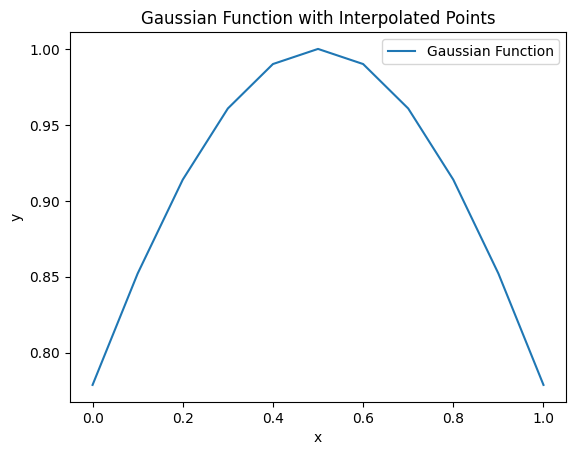

In [100]:
# create y_array as gaussian function
y_array = mx.exp(-((x_array - 0.5) ** 2))
# plot
import matplotlib.pyplot as plt
plt.figure()
plt.plot(x_array, y_array, label='Gaussian Function')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gaussian Function with Interpolated Points')
plt.legend()
plt.show()

In [101]:

# for j in range(size):
# # Extract the 4 points around the index i[j]
# x_array_slice = x_array[int(i[j])-1:int(i[j])+3]
# y_array_slice = y_array[int(i[j])-1:int(i[j])+3]

@mx.compile
def slicing_function(array, j):
    return mx.array([array[j-1], array[j], array[j+1], array[j+2]])

x_array_slice = mx.vmap(slicing_function, in_axes=(None, 0))(x_array, i)
y_array_slice = mx.vmap(slicing_function, in_axes=(None, 0))(y_array, i)



fn_vmap = mx.vmap(cubic_function_4pts_mlx, in_axes=(0, 0, 0, 0))
pred_y = fn_vmap(x_new, x_array_slice, y_array_slice, condition_i)
print(f"x_new: {x_new}")
print(f"Condition: {condition_i}")
print(f"Predicted y values: {pred_y}")

x_new: array([0, 0.25, 0.5, 0.75, 1], dtype=float32)
Condition: array([1, 2, 2, 2, 3], dtype=int32)
Predicted y values: array([0.778801, 0.939393, 1, 0.939393, 0.778801], dtype=float32)


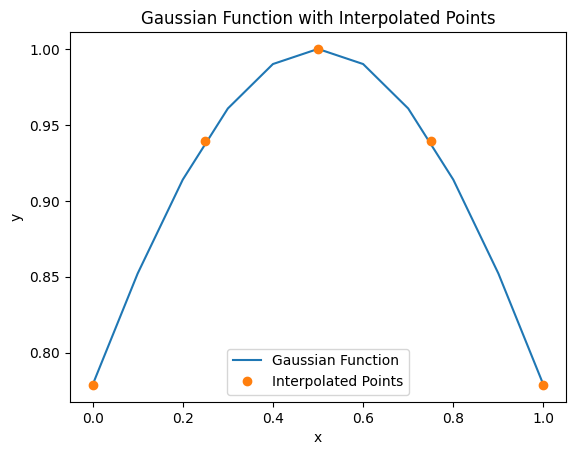

In [102]:
# plot
plt.figure()
plt.plot(x_array, y_array, label='Gaussian Function')
plt.plot(x_new, pred_y, 'o', label='Interpolated Points')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gaussian Function with Interpolated Points')
plt.legend()
plt.show()

In [1]:
import mlx.core as mx
import numpy as np

# Define y_array for demonstration
x_array = mx.arange(0., 1., 0.1, dtype=mx.float32)
y_array = mx.sin(2 * mx.pi * x_array)

size = 5
x_new = mx.linspace(0., 1., size, dtype=mx.float32)

@mx.compile
def find_index_1d_mlx(x_array, x_new):
    N = x_array.shape[0]
    i = mx.sum(x_array <= x_new) - 1
    i = mx.clip(i, 1, N - 3)
    condition_i = mx.where(x_new <= x_array[1], 1,
                  mx.where(x_new >= x_array[N-2], 3, 2))
    return i, condition_i

@mx.compile
def cubic_function_4pts_mlx(x_eval, x_pts, y_pts, condition_i):
    # Linear at boundaries
    denom_left = x_pts[1] - x_pts[0]
    left_val = y_pts[0] + (y_pts[1] - y_pts[0]) * (x_eval - x_pts[0]) / denom_left

    denom_right = x_pts[3] - x_pts[2]
    right_val = y_pts[2] + (y_pts[3] - y_pts[2]) * (x_eval - x_pts[2]) / denom_right

    # Cubic in middle
    x0, x1, x2, x3 = x_pts[0], x_pts[1], x_pts[2], x_pts[3]
    y0, y1, y2, y3 = y_pts[0], y_pts[1], y_pts[2], y_pts[3]
    denom = x2 - x1
    t = (x_eval - x1) / denom

    m1 = ((y2 - y1) / (x2 - x1)) * ((x1 - x0) / (x2 - x0)) + ((y1 - y0) / (x1 - x0)) * ((x2 - x1) / (x2 - x0))
    m2 = ((y3 - y2) / (x3 - x2)) * ((x2 - x1) / (x3 - x1)) + ((y2 - y1) / (x2 - x1)) * ((x3 - x2) / (x3 - x1))

    h00 = (2 * t**3 - 3 * t**2 + 1)
    h10 = (t**3 - 2 * t**2 + t)
    h01 = (-2 * t**3 + 3 * t**2)
    h11 = (t**3 - t**2)

    cubic_val = h00 * y1 + h10 * m1 * denom + h01 * y2 + h11 * m2 * denom

    # Use chained mx.where for multi-way select
    return mx.where(condition_i == 1, left_val,
                   mx.where(condition_i == 3, right_val, cubic_val))

# Vectorize index finder
find_index_1d_vmap = mx.vmap(find_index_1d_mlx, in_axes=(None, 0))
i, condition_i = find_index_1d_vmap(x_array, x_new)

# Prepare slices for each x_new (this must be done in a vectorized way)
# Build a stack of slices per x_new. Each row: 4 values to interpolate.
def gather_slices(x_array, y_array, i):
    # Build array of indices: shape (batch, 4)
    idxs = mx.stack([i-1, i, i+1, i+2], axis=1)  # shape: (batch, 4)
    # Gather for each x_new
    x_pts = mx.take(x_array, idxs)
    y_pts = mx.take(y_array, idxs)
    return x_pts, y_pts


x_pts, y_pts = gather_slices(x_array, y_array, i)

# Vectorize interpolation over batch
fn_vmap = mx.vmap(cubic_function_4pts_mlx, in_axes=(0, 0, 0, 0))
interp = fn_vmap(x_new, x_pts, y_pts, condition_i)

print("x_new:", x_new)
print("interp:", interp)


x_new: array([0, 0.25, 0.5, 0.75, 1], dtype=float32)
interp: array([0, 0.996465, -8.74228e-08, -0.996465, -0.224514], dtype=float32)


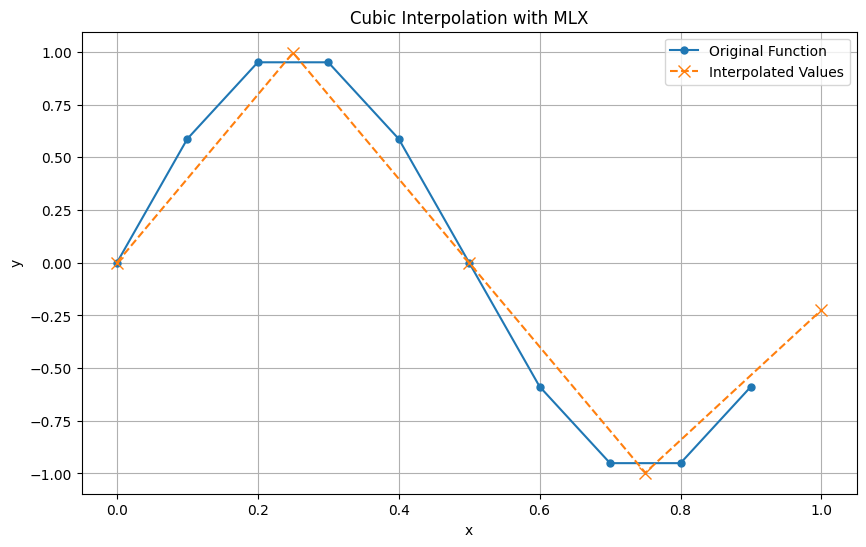

In [104]:
#plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(x_array, y_array, 'o-', label='Original Function', markersize=5)
plt.plot(x_new, interp, 'x--', label='Interpolated Values', markersize=8)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Cubic Interpolation with MLX')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
import mlx.core as mx
import numpy as np

@mx.compile
def find_index_1d_mlx(x_array, x_new):
    N = x_array.shape[0]
    i = mx.sum(x_array <= x_new) - 1
    i = mx.clip(i, 1, N - 3)
    condition_i = mx.where(x_new <= x_array[1], 1,
                  mx.where(x_new >= x_array[N-2], 3, 2))
    return i, condition_i

@mx.compile
def spline_interp_4pts_mlx(x_eval, x_pts, y_pts, condition_i):
    
    # Linear at boundaries
    def left_branch(x_eval, x_pts, y_pts):
        denom_left = x_pts[1] - x_pts[0]
        left_val = y_pts[0] + (y_pts[1] - y_pts[0]) * (x_eval - x_pts[0]) / denom_left
        return left_val

    def right_branch(x_eval, x_pts, y_pts):
        denom_right = x_pts[3] - x_pts[2]
        right_val = y_pts[2] + (y_pts[3] - y_pts[2]) * (x_eval - x_pts[2]) / denom_right
        return right_val

    # Cubic in middle
    def cubic_branch(x_eval, x_pts, y_pts):
        x0, x1, x2, x3 = x_pts[0], x_pts[1], x_pts[2], x_pts[3]
        y0, y1, y2, y3 = y_pts[0], y_pts[1], y_pts[2], y_pts[3]
        denom = x2 - x1
        t = (x_eval - x1) / denom

        m1 = ((y2 - y1) / (x2 - x1)) * ((x1 - x0) / (x2 - x0)) + ((y1 - y0) / (x1 - x0)) * ((x2 - x1) / (x2 - x0))
        m2 = ((y3 - y2) / (x3 - x2)) * ((x2 - x1) / (x3 - x1)) + ((y2 - y1) / (x2 - x1)) * ((x3 - x2) / (x3 - x1))

        h00 = (2 * t**3 - 3 * t**2 + 1)
        h10 = (t**3 - 2 * t**2 + t)
        h01 = (-2 * t**3 + 3 * t**2)
        h11 = (t**3 - t**2)

        cubic_val = h00 * y1 + h10 * m1 * denom + h01 * y2 + h11 * m2 * denom
        return cubic_val


    # Use chained mx.where for multi-way select
    return mx.where(condition_i == 1, left_branch(x_eval, x_pts, y_pts),
                   mx.where(condition_i == 3, right_branch(x_eval, x_pts, y_pts), cubic_branch(x_eval, x_pts, y_pts)))

######### Interpolation 4D #########
@mx.compile
def spline_interp_4x4x4x4pts_mlx(q_array, mtot_array, a1_array, a2_array, snrpartialscaled_array, q_new, mtot_new, a1_new, a2_new):
    """
    Helper function that performs the FULL 4D interpolation for a SINGLE point.
    This function finds indices, slices data, and then uses vmap internally
    to perform interpolation efficiently without Python loops.
    """
    # 1. Find indices and conditions for the new point
    q_idx, int_q = find_index_1d_mlx(q_array, q_new)
    m_idx, int_m = find_index_1d_mlx(mtot_array, mtot_new)
    a1_idx, int_a1 = find_index_1d_mlx(a1_array, a1_new)
    a2_idx, int_a2 = find_index_1d_mlx(a2_array, a2_new)

    # 2. Slice the small 4x4x4x4 cube of data and the corresponding 4-point coordinate arrays
    q_pts = mx.array([q_array[q_idx - 1], q_array[q_idx], q_array[q_idx + 1], q_array[q_idx + 2]])
    m_pts = mx.array([mtot_array[m_idx - 1], mtot_array[m_idx], mtot_array[m_idx + 1], mtot_array[m_idx + 2]])
    a1_pts = mx.array([a1_array[a1_idx - 1], a1_array[a1_idx], a1_array[a1_idx + 1], a1_array[a1_idx + 2]])
    a2_pts = mx.array([a2_array[a2_idx - 1], a2_array[a2_idx], a2_array[a2_idx + 1], a2_array[a2_idx + 2]])

    # # --- Create the 4x4x4x4 data_cube ---
    # # We expand the index arrays with new dimensions so they broadcast correctly
    # # to select a 4x4x4x4 cube from the larger array.
    offsets = mx.arange(-1, 3)
    q_indices  = (q_idx + offsets).reshape(4, 1, 1, 1)
    m_indices  = (m_idx + offsets).reshape(1, 4, 1, 1)
    a1_indices = (a1_idx + offsets).reshape(1, 1, 4, 1)
    a2_indices = (a2_idx + offsets).reshape(1, 1, 1, 4)

    # Perform a single, efficient "gather" operation using the broadcasted indices.
    data_cube = snrpartialscaled_array[q_indices, m_indices, a1_indices, a2_indices]


    # 3. Perform 4D interpolation using vmap to eliminate loops
    # Interpolate along the last dimension (a2) for each of the 4x4x4 slices
    interp_on_a2 = mx.vmap(
        lambda y_slice: spline_interp_4pts_mlx(a2_new, a2_pts, y_slice, int_a2)
    )(data_cube.reshape(64, 4)).reshape(4, 4, 4)

    # Interpolate along the next dimension (a1)
    interp_on_a1 = mx.vmap(
        lambda y_slice: spline_interp_4pts_mlx(a1_new, a1_pts, y_slice, int_a1)
    )(interp_on_a2.reshape(16, 4)).reshape(4, 4)

    # Interpolate along the mtot dimension
    interp_on_m = mx.vmap(
        lambda y_slice: spline_interp_4pts_mlx(mtot_new, m_pts, y_slice, int_m)
    )(interp_on_a1)

    # Final interpolation along the q dimension
    final_snr = spline_interp_4pts_mlx(q_new, q_pts, interp_on_m, int_q)

    return final_snr

# @mx.compile
def spline_interp_4x4x4x4pts_batched_mlx(q_array, mtot_array, a1_array, a2_array, snrpartialscaled_array, q_new_batch, mtot_new_batch, a1_new_batch, a2_new_batch):
    """
    Perform batched 4D cubic spline interpolation using JAX vectorization.
    """
    # Vectorize the complete single-point interpolation function.
    # This is the only vmap call needed at the top level.
    vmapped_interpolator = mx.vmap(
        spline_interp_4x4x4x4pts_mlx,
        in_axes=(None, None, None, None, None, 0, 0, 0, 0)
    )

    # Call the fully vectorized function on the batch data.
    return vmapped_interpolator(
        q_array, mtot_array, a1_array, a2_array, snrpartialscaled_array,
        q_new_batch, mtot_new_batch, a1_new_batch, a2_new_batch
    )

from gwsnr.numba import antenna_response_array

def get_interpolated_snr_aligned_spins_mlx(mass_1, mass_2, luminosity_distance, theta_jn, psi, geocent_time, ra, dec, a_1, a_2, detector_tensor, snr_partialscaled, ratio_arr, mtot_arr, a1_arr, a_2_arr):
    """
    Calculate interpolated signal-to-noise ratio (SNR) for aligned spin gravitational wave signals using JAX.
    This function computes the SNR for gravitational wave signals with aligned spins across multiple 
    detectors using 4D cubic spline interpolation. It calculates the effective distance, partial SNR,
    and combines results from multiple detectors to produce the effective SNR.

    Parameters
    ----------
    mass_1 : jax.numpy.ndarray
        Primary mass of the binary system in solar masses.
    mass_2 : jax.numpy.ndarray  
        Secondary mass of the binary system in solar masses.
    luminosity_distance : jax.numpy.ndarray
        Luminosity distance to the source in Mpc.
    theta_jn : jax.numpy.ndarray
        Inclination angle between the orbital angular momentum and line of sight in radians.
    psi : jax.numpy.ndarray
        Polarization angle in radians.
    geocent_time : jax.numpy.ndarray
        GPS time of coalescence at the geocenter in seconds.
    ra : jax.numpy.ndarray
        Right ascension of the source in radians.
    dec : jax.numpy.ndarray
        Declination of the source in radians.
    a_1 : jax.numpy.ndarray
        Dimensionless spin magnitude of the primary black hole.
    a_2 : jax.numpy.ndarray
        Dimensionless spin magnitude of the secondary black hole.
    detector_tensor : jax.numpy.ndarray
        Detector tensor array containing detector response information.
        Shape: (n_detectors, ...)
    snr_partialscaled : jax.numpy.ndarray
        Pre-computed scaled partial SNR values for interpolation.
        Shape: (n_detectors, ...)
    ratio_arr : jax.numpy.ndarray
        Mass ratio grid points for interpolation (q = m2/m1).
    mtot_arr : jax.numpy.ndarray
        Total mass grid points for interpolation.
    a1_arr : jax.numpy.ndarray
        Primary spin grid points for interpolation.
    a_2_arr : jax.numpy.ndarray
        Secondary spin grid points for interpolation.

    Returns
    -------
    snr : jax.numpy.ndarray
        SNR values for each detector. Shape: (n_detectors, n_samples)
    snr_effective : jax.numpy.ndarray
        Effective SNR combining all detectors. Shape: (n_samples,)
    snr_partial_ : jax.numpy.ndarray
        Interpolated partial SNR values for each detector. Shape: (n_detectors, n_samples)
    d_eff : jax.numpy.ndarray
        Effective distance for each detector accounting for antenna response.
        Shape: (n_detectors, n_samples)

    Notes
    -----
    - Uses 4D cubic spline interpolation for efficient SNR calculation
    - Assumes aligned spins (no precession)
    - Effective SNR is calculated as sqrt(sum(SNR_i^2)) across detectors
    - Chirp mass and inclination-dependent factors are computed analytically
    """

    size = mass_1.shape[0]
    det_len = detector_tensor.shape[0]

    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    snr, snr_effective, snr_partial_, d_eff = get_interpolated_snr_aligned_spins_mlx_(
        mx.array(mass_1), 
        mx.array(mass_2), 
        mx.array(luminosity_distance), 
        mx.array(theta_jn), 
        mx.array(a_1), 
        mx.array(a_2), 
        mx.array(snr_partialscaled), 
        mx.array(ratio_arr), 
        mx.array(mtot_arr), 
        mx.array(a1_arr), 
        mx.array(a_2_arr),
        mx.array(Fp),
        mx.array(Fc),
        size, 
        det_len
    )

    return np.array(snr), np.array(snr_effective), np.array(snr_partial_), np.array(d_eff)

@mx.compile
def get_interpolated_snr_aligned_spins_mlx_(mass_1, mass_2, luminosity_distance, theta_jn, a_1, a_2, snr_partialscaled, ratio_arr, mtot_arr, a1_arr, a_2_arr, Fp, Fc, size, det_len):
    """
    Calculate interpolated signal-to-noise ratio (SNR) for aligned spin gravitational wave signals using JAX.
    This function computes the SNR for gravitational wave signals with aligned spins across multiple 
    detectors using 4D cubic spline interpolation. It calculates the effective distance, partial SNR,
    and combines results from multiple detectors to produce the effective SNR.

    Parameters
    ----------
    mass_1 : jax.numpy.ndarray
        Primary mass of the binary system in solar masses.
    mass_2 : jax.numpy.ndarray  
        Secondary mass of the binary system in solar masses.
    luminosity_distance : jax.numpy.ndarray
        Luminosity distance to the source in Mpc.
    theta_jn : jax.numpy.ndarray
        Inclination angle between the orbital angular momentum and line of sight in radians.
    psi : jax.numpy.ndarray
        Polarization angle in radians.
    geocent_time : jax.numpy.ndarray
        GPS time of coalescence at the geocenter in seconds.
    ra : jax.numpy.ndarray
        Right ascension of the source in radians.
    dec : jax.numpy.ndarray
        Declination of the source in radians.
    a_1 : jax.numpy.ndarray
        Dimensionless spin magnitude of the primary black hole.
    a_2 : jax.numpy.ndarray
        Dimensionless spin magnitude of the secondary black hole.
    detector_tensor : jax.numpy.ndarray
        Detector tensor array containing detector response information.
        Shape: (n_detectors, ...)
    snr_partialscaled : jax.numpy.ndarray
        Pre-computed scaled partial SNR values for interpolation.
        Shape: (n_detectors, ...)
    ratio_arr : jax.numpy.ndarray
        Mass ratio grid points for interpolation (q = m2/m1).
    mtot_arr : jax.numpy.ndarray
        Total mass grid points for interpolation.
    a1_arr : jax.numpy.ndarray
        Primary spin grid points for interpolation.
    a_2_arr : jax.numpy.ndarray
        Secondary spin grid points for interpolation.

    Returns
    -------
    snr : jax.numpy.ndarray
        SNR values for each detector. Shape: (n_detectors, n_samples)
    snr_effective : jax.numpy.ndarray
        Effective SNR combining all detectors. Shape: (n_samples,)
    snr_partial_ : jax.numpy.ndarray
        Interpolated partial SNR values for each detector. Shape: (n_detectors, n_samples)
    d_eff : jax.numpy.ndarray
        Effective distance for each detector accounting for antenna response.
        Shape: (n_detectors, n_samples)

    Notes
    -----
    - Uses 4D cubic spline interpolation for efficient SNR calculation
    - Assumes aligned spins (no precession)
    - Effective SNR is calculated as sqrt(sum(SNR_i^2)) across detectors
    - Chirp mass and inclination-dependent factors are computed analytically
    """
    
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = mx.cos(theta_jn) ** 2
    ci_param = ((1 + mx.cos(theta_jn) ** 2) / 2) ** 2

    snr_partial_ = mx.zeros((det_len,size))
    d_eff = mx.zeros((det_len,size))
    snr = mx.zeros((det_len,size))
    # loop over the detectors
    for j in range(det_len):
        snr_partial_[j] = mx.array(spline_interp_4x4x4x4pts_batched_mlx(
                q_array=ratio_arr,
                mtot_array=mtot_arr,
                a1_array=a1_arr,
                a2_array=a_2_arr,
                snrpartialscaled_array=snr_partialscaled[j],
                q_new_batch=ratio,
                mtot_new_batch=mtot,
                a1_new_batch=a_1,
                a2_new_batch=a_2,
            )
        )

        d_eff[j] = luminosity_distance / mx.sqrt(Fp[j] ** 2 * ci_param + Fc[j] ** 2 * ci_2)
        # Calculate the SNR for this detector
        snr[j] = snr_partial_[j] * A1 / d_eff[j]

    snr_effective = mx.sqrt(mx.sum(snr ** 2, axis=0))

    return snr, snr_effective, snr_partial_, d_eff

In [1]:
from gwsnr import GWSNR

gwsnr = GWSNR(snr_type='interpolation_aligned_spins_mlx')


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_2.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_2.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_2.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  interpolation_aligned_spins_mlx
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  9.96
max(mtot) (with the given fmin=20.0): 235.0
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/

In [2]:
import numpy as np
# gerneral case, random parameters
# add random seed for reproducibility
np.random.seed(0)
nsamples = 10
mtot = np.random.uniform(2*4.98, 2*112.5,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
# convert to component masses
mass_1 = mtot / (1 + mass_ratio)
mass_2 = mtot * mass_ratio / (1 + mass_ratio)
# Fix luminosity distance
luminosity_distance = 500*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra = np.random.uniform(0,2*np.pi, size=nsamples)
dec = np.random.uniform(-np.pi/2,np.pi/2, size=nsamples)
psi = np.random.uniform(0,2*np.pi, size=nsamples)
phase = np.random.uniform(0,2*np.pi, size=nsamples)
geocent_time = 1246527224.169434*np.ones(nsamples)
a_1 = np.random.uniform(-0.8,0.8, size=nsamples)
a_2 = np.random.uniform(-0.8,0.8, size=nsamples)

In [32]:
get_interpolated_snr_aligned_spins_mlx(
    np.array(mass_1),
    np.array(mass_2),
    np.array(luminosity_distance),
    np.array(theta_jn),
    np.array(psi),
    np.array(geocent_time),
    np.array(ra),
    np.array(dec),
    np.array(a_1),
    np.array(a_2),
    np.array(np.array(gwsnr.detector_tensor_list)),
    np.array(np.array(gwsnr.snr_partialsacaled_list)),
    np.array(np.array(gwsnr.ratio_arr)),
    np.array(np.array(gwsnr.mtot_arr)),
    np.array(np.array(gwsnr.a_1_arr)),
    np.array(np.array(gwsnr.a_2_arr)),
)[0][0]

array([83.248985, 39.032387, 75.136475, 29.79174 , 55.85162 ,
       10.121874, 25.88733 , 85.163734, 96.42966 , 45.26053 ],
      dtype=float32)

In [4]:
from gwsnr.numba import get_interpolated_snr_aligned_spins_numba
get_interpolated_snr_aligned_spins_numba(
    np.array(mass_1),
    np.array(mass_2),
    np.array(luminosity_distance),
    np.array(theta_jn),
    np.array(psi),
    np.array(geocent_time),
    np.array(ra),
    np.array(dec),
    np.array(a_1),
    np.array(a_2),
    np.array(np.array(gwsnr.detector_tensor_list)),
    np.array(np.array(gwsnr.snr_partialsacaled_list)),
    np.array(np.array(gwsnr.ratio_arr)),
    np.array(np.array(gwsnr.mtot_arr)),
    np.array(np.array(gwsnr.a_1_arr)),
    np.array(np.array(gwsnr.a_2_arr)),
)[0][0]

array([83.24898409, 39.03238271, 75.13647516, 29.79173197,
       55.8516247 , 10.12187457, 25.8873308 , 85.16373853,
       96.42966823, 45.26053532])

In [3]:
gwsnr.snr(
    mass_1=mass_1,
    mass_2=mass_2,
    luminosity_distance=luminosity_distance,
    theta_jn=theta_jn,
    psi=psi,
    geocent_time=geocent_time,
    ra=ra,
    dec=dec,
    a_1=a_1,
    a_2=a_2
)

{'L1': array([83.24898529, 39.03238678, 75.13647461, 29.79174042,
        55.85161972, 10.12187386, 25.8873291 , 85.16373444,
        96.42965698, 45.26052856]),
 'H1': array([115.69338226,  29.01293182,  65.14109802,  44.07611084,
         41.85443878,  21.1502533 ,  25.62665939,  94.74263763,
         81.39611053,  42.79145432]),
 'V1': array([38.86171722, 46.60929108, 47.07643509, 40.96109009,
        29.52319908, 18.26800537, 23.63890076, 92.64099884,
        63.72468567, 61.52758789]),
 'optimal_snr_net': array([147.73484802,  67.36247253, 110.0229187 ,  67.1421051 ,
         75.78137207,  29.72381973,  43.42438126, 157.51629639,
        141.36775208,  87.55151367])}

In [11]:
import mlx.core as mx

@mx.compile
def trunc_mlx(x):
    return mx.where(x >= 0, mx.floor(x), mx.ceil(x))

@mx.compile
def fmod_mlx(x, y):
    return x - y * trunc_mlx(x / y)

In [13]:
import numpy as np
import mlx.core as mx

x_np = np.array([5.5, -5.5, 5.5, -5.5])
y_np = np.array([2.0, 2.0, -2.0, -2.0])
x_mx = mx.array(x_np)
y_mx = mx.array(y_np)

result_mx = mx.vmap(fmod_mlx)(x_mx, y_mx)
print("MLX fmod:", result_mx)
result_np = np.fmod(x_np, y_np)
print("NumPy fmod:", result_np)

MLX fmod: array([1.5, -1.5, 1.5, -1.5], dtype=float32)
NumPy fmod: [ 1.5 -1.5  1.5 -1.5]


In [5]:
import mlx.core as mx

@mx.compile
def trunc_mlx(x):
    return mx.where(x >= 0, mx.floor(x), mx.ceil(x))

@mx.compile
def fmod_mlx(x, y):
    return x - y * trunc_mlx(x / y)

@mx.compile
def gps_to_gmst(gps_time):
    """
    Function to convert GPS time to Greenwich Mean Sidereal Time (GMST) (JAX implementation).

    Parameters
    ----------
    gps_time : `float`
        GPS time in seconds.

    Returns
    -------
    gmst : `float`
        Greenwich Mean Sidereal Time in radians.

    Notes
    -----
    Uses a linear approximation with a reference time and slope to compute GMST.
    The reference time (time0) is 1126259642.413 seconds and the slope is
    7.292115855382993e-05 radians per second, which approximates Earth's rotation rate.
    JAX implementation supports automatic differentiation for gradient-based optimization.
    """
    slope = 7.292115855382993e-05
    time0 = 1126259642.413
    time = gps_time - time0
    return slope * time + 36137.068361399164

@mx.compile
def ra_dec_to_theta_phi(ra, dec, gmst):
    """
    Function to convert right ascension and declination to spherical coordinates (JAX implementation).

    Parameters
    ----------
    ra : `float`
        Right ascension of the source in radians.
    dec : `float`
        Declination of the source in radians.
    gmst : `float`
        Greenwich Mean Sidereal Time in radians.

    Returns
    -------
    theta : `float`
        Polar angle (colatitude) in radians, measured from the north pole.
    phi : `float`
        Azimuthal angle in radians, adjusted for Earth's rotation.

    Notes
    -----
    Converts celestial coordinates (ra, dec) to spherical coordinates (theta, phi)
    in the detector frame. The azimuthal angle is corrected for Earth's rotation
    using GMST. Theta represents the angle from the north pole (colatitude).
    JAX implementation provides automatic differentiation capabilities for
    parameter estimation and optimization workflows.
    """
    phi = ra - gmst
    theta = mx.pi / 2.0 - dec
    return theta, phi

@mx.compile
def get_polarization_tensor_plus(ra, dec, time, psi):
    """
    Function to calculate the plus polarization tensor for gravitational wave detection (JAX implementation).

    Parameters
    ----------
    ra : `float`
        Right ascension of the source in radians.
    dec : `float`
        Declination of the source in radians.
    time : `float`
        GPS time of the source in seconds.
    psi : `float`
        Polarization angle of the source in radians.

    Returns
    -------
    polarization_tensor_plus : `jax.numpy.ndarray`
        3x3 plus polarization tensor matrix (m⊗m - n⊗n).

    Notes
    -----
    Calculates the plus polarization tensor in the detector frame by first converting
    celestial coordinates to spherical coordinates using GMST, then computing
    the basis vectors m and n based on the polarization angle psi. Returns the
    tensor m⊗m - n⊗n for plus polarization mode. JAX implementation supports
    automatic differentiation and GPU acceleration for efficient computation.
    """
    gmst = fmod_mlx(gps_to_gmst(time), 2 * mx.pi)
    theta, phi = ra_dec_to_theta_phi(ra, dec, gmst)
    u = mx.array([mx.cos(phi) * mx.cos(theta), mx.cos(theta) * mx.sin(phi), -mx.sin(theta)])
    v = mx.array([-mx.sin(phi), mx.cos(phi), 0.])
    m = -u * mx.sin(psi) - v * mx.cos(psi)
    n = -u * mx.cos(psi) + v * mx.sin(psi)

    return mx.outer(m, m) - mx.outer(n, n)
    
@mx.compile
def get_polarization_tensor_cross(ra, dec, time, psi):
    """
    Function to calculate the cross polarization tensor for gravitational wave detection (JAX implementation).

    Parameters
    ----------
    ra : `float`
        Right ascension of the source in radians.
    dec : `float`
        Declination of the source in radians.
    time : `float`
        GPS time of the source in seconds.
    psi : `float`
        Polarization angle of the source in radians.

    Returns
    -------
    polarization_tensor_cross : `jax.numpy.ndarray`
        3x3 cross polarization tensor matrix (m⊗n + n⊗m).

    Notes
    -----
    Calculates the cross polarization tensor in the detector frame by first converting
    celestial coordinates to spherical coordinates using GMST, then computing
    the basis vectors m and n based on the polarization angle psi. Returns the
    tensor m⊗n + n⊗m for cross polarization mode. JAX implementation supports
    automatic differentiation and GPU acceleration for efficient computation.
    """
    gmst = mx.fmod(gps_to_gmst(time), 2 * mx.pi)
    theta, phi = ra_dec_to_theta_phi(ra, dec, gmst)
    u = mx.array([mx.cos(phi) * mx.cos(theta), mx.cos(theta) * mx.sin(phi), -mx.sin(theta)])
    v = mx.array([-mx.sin(phi), mx.cos(phi), 0.])
    m = -u * mx.sin(psi) - v * mx.cos(psi)
    n = -u * mx.cos(psi) + v * mx.sin(psi)

    return mx.outer(m, n) + mx.outer(n, m)

@mx.compile
def antenna_response_plus(ra, dec, time, psi, detector_tensor):
    """
    Function to calculate the plus polarization antenna response for gravitational wave detection (JAX implementation).

    Parameters
    ----------
    ra : `float`
        Right ascension of the source in radians.
    dec : `float`
        Declination of the source in radians.
    time : `float`
        GPS time of the source in seconds.
    psi : `float`
        Polarization angle of the source in radians.
    detector_tensor : `jax.numpy.ndarray`
        Detector tensor for the detector (3x3 matrix).

    Returns
    -------
    antenna_response_plus : `float`
        Plus polarization antenna response of the detector.

    Notes
    -----
    Computes the plus polarization antenna response by calculating the Frobenius
    inner product between the detector tensor and the plus polarization tensor.
    The polarization tensor is determined by the source location (ra, dec),
    observation time, and polarization angle (psi). JAX implementation provides
    automatic differentiation for parameter estimation workflows.
    """
    polarization_tensor = get_polarization_tensor_plus(ra, dec, time, psi)
    return mx.sum(detector_tensor * polarization_tensor)

@mx.compile
def antenna_response_cross(ra, dec, time, psi, detector_tensor):
    """
    Function to calculate the cross polarization antenna response for gravitational wave detection (JAX implementation).

    Parameters
    ----------
    ra : `float`
        Right ascension of the source in radians.
    dec : `float`
        Declination of the source in radians.
    time : `float`
        GPS time of the source in seconds.
    psi : `float`
        Polarization angle of the source in radians.
    detector_tensor : `jax.numpy.ndarray`
        Detector tensor for the detector (3x3 matrix).

    Returns
    -------
    antenna_response_cross : `float`
        Cross polarization antenna response of the detector.

    Notes
    -----
    Computes the cross polarization antenna response by calculating the Frobenius
    inner product between the detector tensor and the cross polarization tensor.
    The polarization tensor is determined by the source location (ra, dec),
    observation time, and polarization angle (psi). JAX implementation provides
    automatic differentiation for parameter estimation workflows.
    """
    polarization_tensor = get_polarization_tensor_cross(ra, dec, time, psi)
    return mx.sum(detector_tensor * polarization_tensor)

@mx.compile
def antenna_response_array(ra, dec, time, psi, detector_tensor):
    """
    Function to calculate the antenna response for multiple detectors and sources (JAX implementation).

    Parameters
    ----------
    ra : `jax.numpy.ndarray`
        Array of right ascension values for sources in radians.
    dec : `jax.numpy.ndarray`
        Array of declination values for sources in radians.
    time : `jax.numpy.ndarray`
        Array of GPS times for sources in seconds.
    psi : `jax.numpy.ndarray`
        Array of polarization angles for sources in radians.
    detector_tensor : `jax.numpy.ndarray`
        Detector tensor array for multiple detectors (n×3×3 matrix), where n is the number of detectors.

    Returns
    -------
    Fp : `jax.numpy.ndarray`
        Plus polarization antenna response array with shape (n_detectors, n_sources).
    Fc : `jax.numpy.ndarray`
        Cross polarization antenna response array with shape (n_detectors, n_sources).

    Notes
    -----
    Computes antenna responses for both plus and cross polarizations across multiple
    detectors and source parameters simultaneously. Uses JAX's vmap for efficient
    vectorized computation with automatic differentiation support. Each antenna
    response is calculated using the Frobenius inner product between detector
    tensors and polarization tensors derived from source sky location and
    polarization angle. Optimized for GPU acceleration and gradient-based optimization.
    """

    # VMAP over detector and parameter axes
    # Outputs shape (n_det, n_param)
    Fp = mx.vmap(
        lambda d: mx.vmap(
            lambda ra_i, dec_i, time_i, psi_i: antenna_response_plus(
                ra_i, dec_i, time_i, psi_i, d
            )
        )(ra, dec, time, psi)
    )(detector_tensor)
    Fc = mx.vmap(
        lambda d: mx.vmap(
            lambda ra_i, dec_i, time_i, psi_i: antenna_response_cross(
                ra_i, dec_i, time_i, psi_i, d
            )
        )(ra, dec, time, psi)
    )(detector_tensor)
    return Fp, Fc

In [3]:
from gwsnr.numba import antenna_response_array as antenna_response_array_numba
from gwsnr.numba import antenna_response_plus as antenna_response_plus_numba
from gwsnr.numba import antenna_response_cross as antenna_response_cross_numba
from gwsnr.numba.njit_functions import gps_to_gmst as gps_to_gmst_numba

In [18]:
# ra, dec, time, psi, detector_tensor
ra = 3.14 / 4.0
dec = 3.14 / 4.0
time = 246527224.169434
psi = 3.14 / 4.0  # Example polarization angle
detector_tensor = gwsnr.detector_tensor_list[0]  # Example for one detector

antenna_response_plus_numba(ra, dec, time, psi, detector_tensor)

-0.7952974796954769

In [21]:
mx.set_default_device(mx.cpu)

dtype_default = mx.float64

# # ra, dec, time, psi, detector_tensor
# ra = mx.array(3.14 / 4.0, dtype=dtype_default)
# dec = mx.array(3.14 / 4.0, dtype=dtype_default)
# time = mx.array(246527224.169434, dtype=dtype_default)
# psi = mx.array(3.14 / 4.0, dtype=dtype_default)  # Example polarization angle
# detector_tensor = mx.array(gwsnr.detector_tensor_list[0])  # Example for one detector

antenna_response_plus(ra, dec, time, psi, mx.array(gwsnr.detector_tensor_list[0], dtype=dtype_default))

array(-0.794866, dtype=float64)

In [40]:
time_mx = mx.array(time, dtype=mx.float32)  # Ensure time is a JAX array

In [43]:
float(time_mx), time

(246527232.0, 246527224.169434)